Ok, now let's make a model. The paper I'm modelling this project on uses a modified version of Structural Deep Neighbor Embedding (SDNE): https://www.kdd.org/kdd2016/papers/files/rfp0191-wangAemb.pdf. There's a very nice implementation of SDNE in keras (along with some other embeddings) here: https://github.com/palash1992/GEM. Instead of creating SDNE from scratch, I'm just going to heavily-modify the SDNE model in the GEM package, so I can compare it to SDNE and other embedding methods. You will need to install my modified GEM, which is in the 'GEM' subdirectory of this project. 

The SDNE model in the GEM package takes one large graph and trains on batches of its edges. There are a few ways we could extend this to our problem- we could pad each team's graph with isolated nodes and feed each team's graph in one at a time, or we could create one big graph formed of several disjoint connected-component graphs consisting of each team's roster. The latter makes more sense here- we want to learn the embedding of each individual player node in the training set and how the properties of each node can be used to predict unobserved edges. In other words, this is an interpolation problem, not an extrapolation problem.

There is one small assumption that goes into combining all the graphs like this- that two blockers with the same name are the same player. Derby names are punny, so it sometimes happens that a good player name like 'Smackpropagation' will show up on a few different teams. However, the nature of our pruning algorithm tends to only give us data for graphs for decently established teams, and this name-similarity problem tends to only show up when we look at small local teams (who are less likely to have enough stats on the FlatTrackStats website). Players also move around a lot since derby is still mostly intramural, so it's much more likely that the same name showing up twice is representative of a player transfer.

The Teammate algorithm randomly removes 20% of the edges from the network, sets this aside as a test network and uses the non-removed 80% as a train network. We need to do this too. I'm also setting 10% aside as a validation 'tuning' set, to tweak the model, so my split is 80-10-10.


The Teammate paper uses random-walk sampling on the test set. Because our graph is made of several disjoint components rather than one large LCC, I'm not entirely convinced this step will do anything for us, so I'll leave it out for now. Because we are only learning observed edges, not null ones, and the random subsampling procedure described in the Team Composition paper can create disconnected graphs that are then fed into the autoencoder, it doesn't seem like strongly-connectedness is necessarily important for the Teammate algorithm to work. Spectral-decomposition based algorithms do require strong-connectivity, but this one does not.


In [3]:
import matplotlib.pyplot as plt
from time import time

from gem.utils      import graph_util, plot_util
from gem.evaluation import visualize_embedding as viz
from gem.evaluation import evaluate_graph_reconstruction as gr

from gem.embedding.gf       import GraphFactorization
from gem.embedding.hope     import HOPE
from gem.embedding.lap      import LaplacianEigenmaps
from gem.embedding.lle      import LocallyLinearEmbedding
from gem.embedding.node2vec import node2vec
import networkx as nx
from gem.embedding.teammate     import Teammate
from gem.embedding.sdne     import SDNE
from argparse import ArgumentParser

This part is a little tricky- we want to make sure the train, val, and test graphs all have the same number of nodes, even if they contain different edge sets (NetworkX will relabel the nodes if we read in the edge lists directly, which will scramble our data). To do this, we read the full, un-split graph in, copy it three times, and then throw away all edges that aren't in the relevant edgelist from each.

In [5]:
# File that contains the edges. Format: source target
# Optionally, you can add weights as third column: source target weight
edge_tot = 'Data/AllTeamsFullLTGraphNormalized.edgelist'
edge_train = 'Data/AllTeamsLTGraphTrainNormalized.edgelist'
edge_test = 'Data/AllTeamsLTGraphTestNormalized.edgelist'
edge_val = 'Data/AllTeamsLTGraphValNormalized.edgelist'
# Specify whether the edges are directed
isDirected = True
# Load graph. Have to prune manually to keep number of nodes fixed
G = nx.read_weighted_edgelist(edge_tot, nodetype=int)
G_test_dummy = nx.read_weighted_edgelist(edge_test, nodetype=int)
G_train_dummy = nx.read_weighted_edgelist(edge_train, nodetype=int)
G_val_dummy = nx.read_weighted_edgelist(edge_val, nodetype=int)

G = G.to_directed()
G_train = G.copy()
G_val = G.copy()
G_test = G.copy()
for edge in G.edges():
    if edge not in G_train_dummy.edges(): G_train.remove_edge(*edge)
    if edge not in G_test_dummy.edges(): G_test.remove_edge(*edge)
    if edge not in G_val_dummy.edges(): G_val.remove_edge(*edge)

print(len(G_train))
print(len(G_test))
print(len(G_val))

print(G.number_of_edges())
print(G_train.number_of_edges())
print(G_val.number_of_edges())
print(G_test.number_of_edges())


3925
3925
3925
50225
40182
5022
5021


For the teammate algorithm, the loss function should be the same as SDNE i.e. (L = $\sum_{i=1}^{n} |(\hat{x}_{i}-x_{i})  \odot [b_{(i,j)}]_{j=1}^{n}|^{2}$) but with the follwing change:

Base SDNE: $b_{(i,j)} = 1$ if $(i,j)= 0, b_{(i,j)} = \beta > 1$ otherwise.

Teammate Encoder SDNE: $b_{(i,j)} = 0$ if $(i,j)= 0, b_{(i,j)} = 1$ otherwise.

In standard SDNE, the loss function penalizes null edges. However, we don't just want to penalize them- we want to completely ignore them. We're not trying to predict *if* players have played together, just how well they do play together when they do. The base SDNE also has a parameter $\alpha$ that controls the first-order loss via the method of Laplacian Eigenmaps, but if we set this to zero we will reconstruct the 'simple' loss function given in the Teammate paper.

These modified embedding methods are implemented in 'teammate.py' and 'teammate_utils.py'. I've also modified the SDNE method to take validation data and show me the loss curve history, and to use a simple linear activation function in the last layer (I'm not sure why the default doesn't use this- it's an autoencoder, after all).

Let's compare the Teammate encoder to SDNE (with the same set of hyperparameters), as well as the default HOPE embedding. The SDNE and HOPE algorithms are not optimized separately- I'm just using them as a baseline for comparison at the moment (I should go back and do this later, though- I know comparing largely-optimized algorithms to un-optimized ones is sloppy ML practice, but I want to limit the scope of this project for now).

I've tuned the Teammate encoder using the validation set to get the Teammate hyperparams. I've found that:
- increasing the size of the embedding dimension improves performance. I've chosen an embedding size of 4, to balance the tradeoff between performance and keeping a bottleneck that is small enough to make sense.
- Adding a larger third layer of 166 neurons only improves performance on both MANE and MSE by about 0.5%. This may be significant for some applications, but for now, I'm more interested in creating a network that is small and fast.
- Adding a small alpha term (1e-5) reduces validation MSE and MANE by about 2%.
- Adding L1 and L2 regularization terms reduces validation MSE by about 5% and MANE by about 0.7%, but dramatically increase the time it takes the model to train. For now, I'm leaving these terms out.
- Rho governs network size limits, so I've set it to be arbitrarily large so I can fiddle with the parameters manually.
- 50 seems to be close to the optimal minibatch size.
- Training typically converges around epoch 25 if not sooner, provided the regularization terms aren't included.

In [7]:
models = []
    # Load the models you want to run
    #models.append(GraphFactorization(d=2, max_iter=50000, eta=1 * 10**-4, regu=1.0))
models.append(HOPE(d=4, beta=0.01))
    #models.append(LaplacianEigenmaps(d=2))
    #models.append(LocallyLinearEmbedding(d=2))

    
#alpha = 0 to have "traditional" second order loss
models.append(Teammate(d=4, alpha=1e-5, nu1=0, nu2=0, K=2,n_units=[50,15], rho=0.99, n_iter=25, xeta=0.01, n_batch=50,
                modelfile=['enc_model_teammate.json', 'dec_model_teammate.json'],
                weightfile=['enc_weights_teammate.hdf5', 'dec_weights_teammate.hdf5']))

models.append(SDNE(d=4, alpha=1e-5, beta=5, nu1=0, nu2=0, K=2,n_units=[50,15], rho=0.99, n_iter=25, xeta=0.01, n_batch=50,
                modelfile=['enc_model_sdne.json', 'dec_model_sdne.json'],
                weightfile=['enc_weights_sdne.hdf5', 'dec_weights_sdne.hdf5']))


We'll also need to implement the MSE, AvgRec@k and MANE methods of measuring graph reconstruction ability. I've added these metrics to the 'metrics.py' file. I'm also tweaking the definition of MANE defined in the paper: rather than dividing by $|E_{i}^{train}||E_{i}^{test}|$, I'm dividing by $max(\lfloor\frac{|E_{i}|^{2}}{2}\rfloor,1)$. This way, I can get a separate train and test MANE which ranges from zero to one.

Broadly, if an embedding method works well:

- MSE should be close to zero- the network reconstructs seen weights close to their correct values
- AvgRec@k should be comparable for the "true" and "predicted" links. AvgRec@k measures the sum of the highest k weights; we expect that a network that models performance well should correctly predict the best player pairs.
- MANE should be small. MANE measures the difference in ranking (i.e. relative magnitude of connection weights) for each node's connections (measured only over the subset of observed links). A good embedding should allow us to reconstruct the relative order of rankings fairly well. 

Num nodes: 3925, num edges: 50225
SVD error (low rank): 0.455906
hope_gsvd:
	Training time: 3.413350
MANE train is  0.5632784947136604
avgrec 10 pred train is  0.00328798642538777
avgrec 10 true is  0.45734774104205045
MSE train is  0.05122105169988352
Embedding dimension greater than 2, use tSNE to reduce it to 2


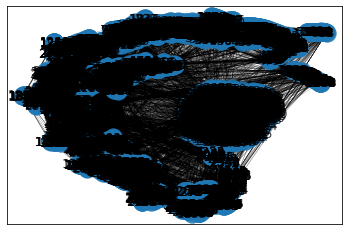

MANE val is  0.26193889338974424
avgrec 10 pred val is  0.00328798642538777
avgrec 10 true val is  0.3721637515480952
MSE val is  0.05128586043873082
Embedding dimension greater than 2, use tSNE to reduce it to 2


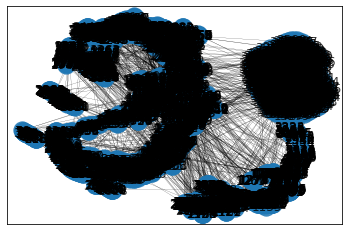

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [8]:
# For each model, learn the embedding and evaluate on graph reconstruction and visualization
for num,embedding in enumerate(models):
    print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
    t1 = time()
        # Learn embedding - accepts a networkx graph or file with edge list

    if num == 0:
        Y, t = embedding.learn_embedding(graph=G_train,edge_f=None, is_weighted=True, no_python=True)
    else:
        Y, t = embedding.learn_embedding(graph=G_train,valgraph=G_val,edge_f=None, is_weighted=True, no_python=True)
    print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
     # Evaluate on graph reconstruction:train
    MANE, avgrecpred, avgrectrue, err, err_baseline = gr.evaluateStaticGraphReconstruction(G_train, embedding, Y, None, is_weighted=True, is_undirected=False)
    print("MANE train is ",MANE)
    print("avgrec 10 pred train is ",avgrecpred)
    print("avgrec 10 true is ",avgrectrue)
    print("MSE train is ",pow(err,2)/G_train.number_of_edges())
    viz.plot_embedding2D(embedding.get_embedding(), di_graph=G_train, node_colors=None)
    plt.show()
    plt.clf()

    # Evaluate on graph reconstruction:val
    MANE, avgrecpred, avgrectrue, err, err_baseline = gr.evaluateStaticGraphReconstruction(G_val, embedding, Y, None, is_weighted=True, is_undirected=False)
    print("MANE val is ",MANE)
    print("avgrec 10 pred val is ",avgrecpred)
    print("avgrec 10 true val is ",avgrectrue)
    print("MSE val is ",pow(err,2)/G_val.number_of_edges())
    viz.plot_embedding2D(embedding.get_embedding(), di_graph=G_val, node_colors=None)
    plt.show()
    plt.clf()
  
    # Evaluate on graph reconstruction: test
    MANE, avgrecpred, avgrectrue, err, err_baseline = gr.evaluateStaticGraphReconstruction(G_test, embedding, Y, None, is_weighted=True, is_undirected=False)
    print("MANE val is ",MANE)
    print("avgrec 10 pred val is ",avgrecpred)
    print("avgrec 10 true val is ",avgrectrue)
    print("MSE val is ",pow(err,2)/G_test.number_of_edges())
    viz.plot_embedding2D(embedding.get_embedding(), di_graph=G_test, node_colors=None)
    plt.show()
    plt.clf()



And we're done! Here are my conclusions:
- The teammate encoder does work well, as a model. It outperforms base SDNE in terms of calculating MANE, and can get very good results with an extremely lightweight network. We've built a recommender system that works! Applications for a tool like this include quickly integrating players into a new team after transferring, or determining smart ways to rearrange lineups of existing teams.
- The disconnectedness of the Derby graphs doesn't really seem to faze the model. 
- Surprisingly, the default HOPE embedding seems to outperform the Teammate encoder in terms of correctly predicting rankings. It doesn't correctly guess the magnitude of player performance gains (AvgRec@k, MSE) as often as Teammate, but it does have a lower MANE, which means it's generally ranking the players correctly more often than the others even if it doesn't produce meaningful statistics from these rankings. I'm not entirely certain why this is; this definitely merit investigating further.

Thanks for following this project!